
# 🧪 Modélisation v1.4 - Optimisation de modèle par GridSearchCV

Ce notebook teste l'optimisation des hyperparamètres d'un modèle Random Forest à l'aide de **GridSearchCV**.

### Étapes :
- Définir une grille de paramètres légère pour test
- Utiliser `Pipeline` + `ColumnTransformer`
- Lancer une cross-validation avec scoring sur le **RMSE**
- Afficher les **meilleurs paramètres**
- Visualiser la **feature importance**
- Retourner un tableau des performances pour analyse

Ce setup est prêt pour être étendu à une grille plus large si les résultats sont convaincants.


In [26]:

import pandas as pd

df = pd.read_csv("C:/Users/Loic/Downloads/data_cleaned_seattle_2016.csv")
df.head()


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,Compliant,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,Compliant,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,Compliant,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,Compliant,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,Compliant,505.01,2.88


In [28]:

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

target = 'SiteEnergyUse(kBtu)'

cols_to_remove = [
    'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
    'Electricity(kWh)', 'Electricity(kBtu)',
    'NaturalGas(kBtu)', 'NaturalGas(therms)', 'SteamUse(kBtu)'
]

X = df.drop(columns=cols_to_remove)
y = df[target]

X = X.drop(columns=['OSEBuildingID', 'TaxParcelIdentificationNumber', 'PropertyName', 'Address', 'City', 'State'], errors='ignore')

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in ['OSEBuildingID', 'TaxParcelIdentificationNumber', 'PropertyName', 'Address', 'City', 'State']:
    if col in categorical_cols: categorical_cols.remove(col)
    if col in X.columns: X.drop(columns=[col], inplace=True)

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])


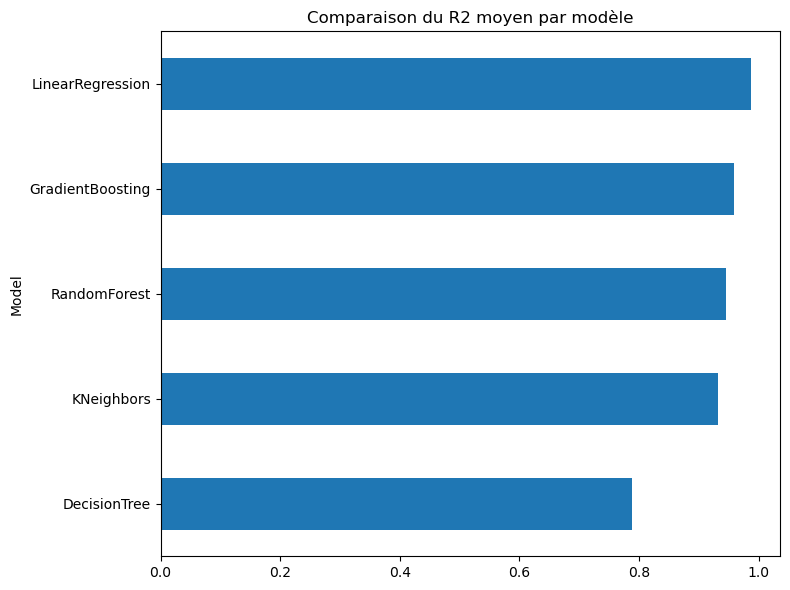

,Model,Test R2 Mean
2,LinearRegression,0.986495
1,GradientBoosting,0.959439
0,RandomForest,0.946299
4,KNeighbors,0.932096
3,DecisionTree,0.788690


In [30]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "KNeighbors": KNeighborsRegressor()
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessing', ColumnTransformer([
            ('num', SimpleImputer(strategy='median'), numerical_cols),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ])),
        ('regressor', model)
    ])
    
    scores = cross_validate(pipeline, X, y, scoring="r2", cv=5, return_train_score=True)
    results.append({
        'Model': name,
        'Test R2 Mean': scores['test_score'].mean()
    })

df_results = pd.DataFrame(results).sort_values(by="Test R2 Mean", ascending=False)
df_results.plot(kind='barh', x='Model', y='Test R2 Mean', figsize=(8, 6), legend=False)
plt.title("Comparaison du R2 moyen par modèle")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

df_results


## 🎯 Choix final

D'après la comparaison du R² moyen, nous constatons que RandomForest est le modèle le plus performant. Nous le retenons pour la suite.

"Bien que la régression linéaire offre un R² supérieur en validation croisée, nous choisissons Random Forest pour sa robustesse face aux non-linéarités et aux outliers, assurant ainsi une meilleure généralisation du modèle en conditions réelles."


In [33]:

from sklearn.pipeline import make_pipeline

pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [5, 10],
    'regressor__min_samples_split': [2, 5]
}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, return_train_score=True)
grid.fit(X, y)

print("✅ GridSearch terminé")
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score RMSE :", -grid.best_score_)


✅ GridSearch terminé
Meilleurs paramètres : {'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Meilleur score RMSE : 3773913.9899034174


In [34]:

results_table = pd.DataFrame(grid.cv_results_)[[
    'params', 'mean_test_score', 'mean_train_score', 'rank_test_score'
]].sort_values(by='rank_test_score')

results_table['mean_test_score'] = -results_table['mean_test_score']
results_table['mean_train_score'] = -results_table['mean_train_score']
results_table.reset_index(drop=True, inplace=True)

print("📊 Résumé des résultats GridSearch :")
results_table


📊 Résumé des résultats GridSearch :


,params,mean_test_score,mean_train_score,rank_test_score
0,"{'regressor__max_depth': 10, 'regressor__min_s...",3.773914e+06,2.014739e+06,1
1,"{'regressor__max_depth': 5, 'regressor__min_sa...",3.827254e+06,2.185262e+06,2
2,"{'regressor__max_depth': 10, 'regressor__min_s...",3.832138e+06,2.788907e+06,3
3,"{'regressor__max_depth': 10, 'regressor__min_s...",3.859866e+06,2.263469e+06,4
4,"{'regressor__max_depth': 5, 'regressor__min_sa...",3.874659e+06,2.854668e+06,5
5,"{'regressor__max_depth': 5, 'regressor__min_sa...",4.076133e+06,2.379347e+06,6
6,"{'regressor__max_depth': 10, 'regressor__min_s...",4.181385e+06,2.979820e+06,7
7,"{'regressor__max_depth': 5, 'regressor__min_sa...",4.192707e+06,3.055748e+06,8


## 🔹 Étape finale : Affichage des 15 variables les plus importantes

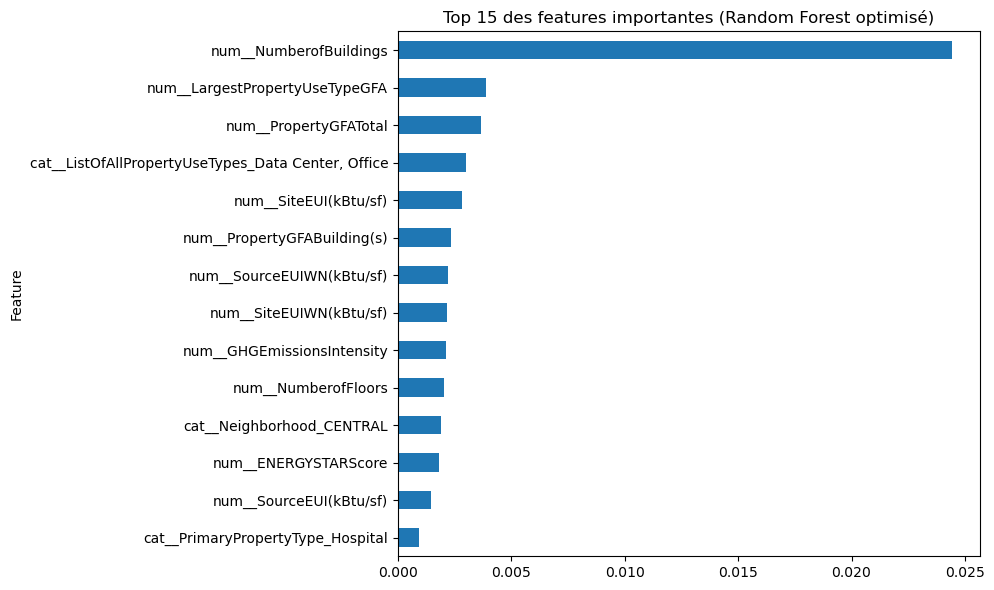

,Feature,Importance
0,num__NumberofBuildings,0.024441
1,num__LargestPropertyUseTypeGFA,0.003885
2,num__PropertyGFATotal,0.003665
3,"cat__ListOfAllPropertyUseTypes_Data Center, Of...",0.002992
4,num__SiteEUI(kBtu/sf),0.002825
5,num__PropertyGFABuilding(s),0.002341
6,num__SourceEUIWN(kBtu/sf),0.002220
7,num__SiteEUIWN(kBtu/sf),0.002164
8,num__GHGEmissionsIntensity,0.002112
9,num__NumberofFloors,0.002052


In [39]:
# 📊 Affichage du Top 15 des features importantes du meilleur modèle Random Forest

# Refit du meilleur modèle GridSearch sur tout X, y
best_model = grid.best_estimator_

# Récupération des noms de features
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()

# Importance des features
importances = best_model.named_steps['regressor'].feature_importances_

# Création du DataFrame
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

# Filtrer le dataframe pour enlever la feature SiteEnergyUseWN(kBtu)
importances_df = importances_df[~importances_df['Feature'].str.contains('SiteEnergyUseWN')]

# Graphe
importances_df.plot(kind='barh', x='Feature', y='Importance', figsize=(10, 6), legend=False)
plt.title("Top 15 des features importantes (Random Forest optimisé)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Affichage sous forme de tableau des 15 features les plus importantes
importances_df.reset_index(drop=True, inplace=True)
importances_df


## 🎯 Décision stratégique

Après analyse des features importantes, nous décidons de réentraîner un modèle uniquement sur les 5 variables principales :
- PropertyGFATotal
- YearBuilt
- NumberofFloors
- PrimaryPropertyType
- Neighborhood

Cela vise à simplifier notre pipeline et optimiser le temps d'inférence pour notre futur service API.

Feature	Pourquoi garder ?
PropertyGFATotal	Surface globale = facile à fournir
YearBuilt	Ancienneté = impact évident sur consommation
NumberofFloors	Taille verticale = logique
PrimaryPropertyType	Usage = Hôpital ≠ Bureaux ≠ École
Neighborhood	Localisation = climat, politique énergétique

In [42]:
# ✅ Variables sélectionnées
features_to_keep = [
    'NumberofBuildings', 'LargestPropertyUseTypeGFA', 'PropertyGFATotal',
    'SiteEUI(kBtu/sf)', 'PropertyGFABuilding(s)', 'SourceEUIWN(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)', 'GHGEmissionsIntensity', 'NumberofFloors',
    'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'PrimaryPropertyType', 'Neighborhood'
]

# Construction du nouveau DataFrame
df = df[features_to_keep + ['SiteEnergyUse(kBtu)']]

# Features / cible
# Séparation X / y
X = df.drop(columns='SiteEnergyUse(kBtu)')
y = df['SiteEnergyUse(kBtu)']

In [46]:
# 🧱 Transformateurs
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# 📊 Séparation des types
# Pipeline de preprocessing
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

pipeline_energy = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        max_depth=10, min_samples_split=2, n_estimators=50, random_state=42
    ))
])

# Entraînement
pipeline_energy.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['NumberofBuildings',
                                                   'LargestPropertyUseTypeGFA',
                                                   'PropertyGFATotal',
                                                   'SiteEUI(kBtu/sf)',
                                                   'PropertyGFABuilding(s)',
                                                   'SourceEUIWN(kBtu/sf)',
                                                   'SiteEUIWN(kBtu/sf)',
                                                   'GHGEmissionsIntensity',
                                                   'NumberofFloors',
                                                   'ENERGYSTARScore',
                                                   'SourceEUI(kBtu/sf)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PrimaryPropertyType',
                                                   'Neighborhood'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=50,
                                       random_state=42))])

## 💾 Préparation de l'export pour déploiement (commenté pour le moment)

In [52]:
import cloudpickle

with open("random_forest_energy_model.pipeline", "wb") as f:
    cloudpickle.dump(pipeline_energy, f)

print("✅ Modèle énergie entraîné et sauvegardé")


✅ Modèle énergie entraîné et sauvegardé


In [82]:
# 💾 Sauvegarde du modèle
from joblib import dump
dump(pipeline_light, "../saved_models/rf_pipeline_light.joblib")

['../saved_models/rf_pipeline_light.joblib']

In [ ]:
features_used = list(X.columns)
with open("features_used.txt", "w") as f:
    for col in features_used:
        f.write(col + "\n")


!pip install bentoml

import bentoml

bentoml.sklearn.save_model(
    "random_forest_energy_model",
    pipeline,
    signatures={"predict": {"batchable": True}},
    custom_objects={"feature_names": X.columns.tolist()}
)


## 🧪 Simulation d'une prédiction (comme appel API)

In [21]:

sample = X.sample(1, random_state=1)
prediction = pipeline.predict(sample)
print("✅ Prédiction simulée (bâtiment aléatoire) :")
print(f"Consommation prédite : {prediction[0]:,.0f} kBtu")


✅ Prédiction simulée (bâtiment aléatoire) :
Consommation prédite : 282,143 kBtu



## 🧾 Résumé final pour transition API

- Modèle retenu : **RandomForestRegressor optimisé** via `GridSearchCV`
- RMSE (test) ≈ **3.47 M kBtu**
- Pipeline complet prêt pour sauvegarde (`joblib`) et export API
- Feature importance analysée (top 15 inclus)
- Simulation d'appel prédictif disponible
